## Imports principais

In [1]:
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import scipy.stats as stats
from sklearn.decomposition import PCA
#import osmnx as ox
#networkx.algorithms.community.community_generators.LFR_benchmark_graph
from networkx.algorithms.community.community_generators import LFR_benchmark_graph
from networkx.algorithms import community
from community import community_louvain
from networkx.algorithms.community.quality import modularity
from networkx.algorithms.community.modularity_max import greedy_modularity_communities
from sklearn.metrics import normalized_mutual_info_score as nmi
import igraph
import warnings
import operator
#warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

## Definições de funções
### Aqui serão definidas as funções utilizadas no restante do código, facilitando a leitura do código nos enunciados.


In [2]:
def betweenessCentrality(graph):
    x = dict(nx.betweenness_centrality(graph))
    x = pd.Series(x)
    return x

def closenessCentrality(graph):
    x = dict(nx.closeness_centrality(graph))
    x = pd.Series(x)
    return x

def communicabilityCentrality(graph):
    x = pd.DataFrame(nx.communicability_exp(graph))
    x = pd.Series(np.diag(x))
    return x

def degrees(graph):
    x = dict(nx.degree(graph))
    x = pd.Series(x)
    return x

def eigenVectorCentrality(graph,max_iter=100):
    x = dict(nx.eigenvector_centrality(graph, max_iter=max_iter))
    x = pd.Series(x)
    return x

def kCore(graph):
    x = dict(nx.core_number(graph))
    x = pd.Series(x)
    return x

def knnDegree(graph):
    x = dict(nx.average_degree_connectivity(graph))
    degrees = pd.Series(list(x.keys()))
    knn = pd.Series(list(x.values()))
    return degrees, knn

def pageRank(graph, alpha=0.85):
    x = dict(nx.pagerank(graph, alpha=alpha))
    x = pd.Series(x)
    return x

def plotCorr(corr):
    import matplotlib.pyplot as plt
    f = plt.figure(figsize=(10, 10))
    plt.matshow(corr, fignum=f.number)
    plt.xticks(range(corr.shape[0]), corr.columns, fontsize=12, rotation=90)
    plt.yticks(range(corr.shape[1]), corr.columns, fontsize=12)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=12)
    plt.title('Correlation Matrix', fontsize=14,y=1);
    plt.show()

#Fonte: Material de aula
def printInfo(graph):
    N = len(graph)
    M = graph.number_of_edges()
    print('Nós:', N)
    print('Arestas:', M)
    print('Grau Médio:', 2*M/N)

#Similar ao da lista 1, mas saída está em pd.Series    
def random_walk(g, steps=100):
    g_mat = nx.to_numpy_array(g, nodelist=sorted(g.nodes()))    
    path = np.zeros((steps,), dtype=np.int64)
    step = 0
    for i in range(steps-1):
        path[i] = step
        step = np.random.choice(np.arange(g_mat.shape[1])[g_mat[step, :] > 0.0])
    path[i+1] = step
    return pd.Series(path)

#m ==> degree of the moment
def moment(vector, m):
    total = vector.sum()
    probs = vector / total
    moment = np.sum((vector**m)*probs)
    return moment

def shannonEntropy(vector):
    total = vector.sum()
    probs = vector / total
    H = np.sum(np.array([probs[i]*np.log2(probs[i]) if probs[i] != 0 else 0 for i in range(0,len(vector))]))
    H *= -1
    return H
    


## Leitura dos grafos principais (apenas o maior componente conexo é mantido).

In [3]:
# Airport
airport = nx.read_edgelist("datasets/USairport_2010.txt", nodetype=int, data=(('weight',float),))
airport = airport.to_undirected()
airport = max(nx.connected_component_subgraphs(airport), key=len)
airport = nx.convert_node_labels_to_integers(airport, first_label=0)
print("\n\nUSA Airport")
printInfo(airport)

# c-elegans neural
celegans = nx.read_edgelist('datasets/C-elegans-frontal.txt')
celegans = celegans.to_undirected()
celegans = max(nx.connected_component_subgraphs(celegans), key=len)
celegans = nx.convert_node_labels_to_integers(celegans, first_label=0)
print("\n\nC-Elegans")
print("Fonte: https://snap.stanford.edu/data/C-elegans-frontal.html\nA versao em .gml estava dando erro.")
printInfo(celegans)

# c-elegans 2004
celegans2004 = nx.read_edgelist('datasets/C-elegans-2004.txt')
celegans2004 = max(nx.connected_component_subgraphs(celegans2004), key=len)
celegans2004 = celegans2004.to_undirected()
celegans2004.remove_edges_from(nx.selfloop_edges(celegans2004))
celegans2004 = nx.convert_node_labels_to_integers(celegans2004, first_label=0)
print("\n\nC-Elegans 2004")
printInfo(celegans2004)

# c-elegans 2007
celegans2007 = nx.read_edgelist('datasets/C-elegans-2007.txt')
celegans2007 = celegans2007.to_undirected()
celegans2007.remove_edges_from(nx.selfloop_edges(celegans2007))
celegans2007 = max(nx.connected_component_subgraphs(celegans2007), key=len)
celegans2007 = nx.convert_node_labels_to_integers(celegans2007, first_label=0)
print("\n\nC-Elegans 2007")
printInfo(celegans2007)

#E-Roads
e_road = nx.read_edgelist('datasets/euroroad', comments='%')
e_road = e_road.to_undirected()
e_road = max(nx.connected_component_subgraphs(e_road), key=len)
e_road = nx.convert_node_labels_to_integers(e_road, first_label=0)
print("E-Roads")
printInfo(e_road)

# Hamsterster Friends
ham = nx.read_edgelist('datasets/hamsterster', comments='%')
ham = max(nx.connected_component_subgraphs(ham), key=len)
ham = ham.to_undirected()
ham = nx.convert_node_labels_to_integers(ham, first_label=0)
print("\n\nHamsterster Friends")
printInfo(ham)

#Human Protein
protein = nx.read_edgelist("datasets/out.maayan-vidal", comments='%')
protein = max(nx.connected_component_subgraphs(protein), key=len)
protein = protein.to_undirected()
protein.remove_edges_from(nx.selfloop_edges(protein))
protein = nx.convert_node_labels_to_integers(protein, first_label=0)
print("\n\nHuman Protein")
printInfo(protein)

#Karate Club
karate = nx.karate_club_graph()
karate = max(nx.connected_component_subgraphs(karate), key=len)
karate = karate.to_undirected()
karate = nx.convert_node_labels_to_integers(karate, first_label=0)
print("\n\nKarate Club")
printInfo(karate)

#Power Grid
power_grid = nx.read_gml('datasets/power.gml', label=None)
power_grid = max(nx.connected_component_subgraphs(power_grid), key=len)
power_grid = power_grid.to_undirected()
power_grid.remove_edges_from(nx.selfloop_edges(power_grid))
power_grid = nx.convert_node_labels_to_integers(power_grid, first_label=0)
print("\n\nPower Grid")
printInfo(power_grid)

#R Dependencies
r_dependencies = nx.read_edgelist('datasets/Rdependencies.csv', comments='%', delimiter=',',nodetype=str)
r_dependencies = max(nx.connected_component_subgraphs(r_dependencies), key=len)
r_dependencies = r_dependencies.to_undirected()
r_dependencies.remove_edges_from(nx.selfloop_edges(r_dependencies))
r_dependencies = nx.convert_node_labels_to_integers(r_dependencies, first_label=0)

print("\n\nR Dependencies")
printInfo(r_dependencies)

#4 Cidades
#Colocar leitura das 4 cidades aqui usando osmnx como plkaceholder
#clovelly = ox.graph_from_place('Clovelly, Devon, South West England, England, EX39 5TQ, United Kingdom', which_result=2)
#walsdorf = ox.graph_from_place('Walsdorf, Landkreis Bamberg, Upper Franconia, Bavaria, 96194, Germany', which_result=1)
#emilion = ox.graph_from_place('Saint-Émilion, Libourne, Gironde, New Aquitaine, Metropolitan France, 33330, France', which_result=1)


#Besalu
with open('datasets/besalu','rb') as gfile:
    besalu = pickle.load(gfile)
besalu = besalu.to_undirected()
besalu = max(nx.connected_component_subgraphs(besalu), key=len)
besalu = nx.convert_node_labels_to_integers(besalu, first_label=0)
print("\n\nBesalu")
printInfo(besalu)


#Clovelly
with open('datasets/clovelly','rb') as gfile:
    clovelly = pickle.load(gfile)
clovelly = clovelly.to_undirected()
clovelly = max(nx.connected_component_subgraphs(clovelly), key=len)
clovelly = nx.convert_node_labels_to_integers(clovelly, first_label=0)
print("\n\nClovelly")
printInfo(clovelly)

#Walsdorf
with open('datasets/walsdorf','rb') as gfile:
    walsdorf = pickle.load(gfile)
walsdorf = walsdorf.to_undirected()
walsdorf = max(nx.connected_component_subgraphs(walsdorf), key=len)
walsdorf = nx.convert_node_labels_to_integers(walsdorf, first_label=0)
print("\n\nWalsdorf")
printInfo(walsdorf)

#Emilion
with open('datasets/emilion','rb') as gfile:
    emilion = pickle.load(gfile)
emilion = emilion.to_undirected()
emilion = max(nx.connected_component_subgraphs(emilion), key=len)
emilion = nx.convert_node_labels_to_integers(emilion, first_label=0)
print("\n\nEmilion")
printInfo(emilion)

allCities = [(besalu,'Besalu'),(clovelly,'clovelly'), (walsdorf,'walsdorf'), (emilion,'emilion')]




USA Airport
Nós: 1572
Arestas: 17214
Grau Médio: 21.900763358778626


C-Elegans
Fonte: https://snap.stanford.edu/data/C-elegans-frontal.html
A versao em .gml estava dando erro.
Nós: 131
Arestas: 687
Grau Médio: 10.488549618320612


C-Elegans 2004
Nós: 1084
Arestas: 1602
Grau Médio: 2.955719557195572


C-Elegans 2007
Nós: 1108
Arestas: 1500
Grau Médio: 2.707581227436823
E-Roads
Nós: 1039
Arestas: 1305
Grau Médio: 2.512030798845043


Hamsterster Friends
Nós: 1788
Arestas: 12476
Grau Médio: 13.955257270693512


Human Protein
Nós: 2783
Arestas: 6007
Grau Médio: 4.316924182536831


Karate Club
Nós: 34
Arestas: 78
Grau Médio: 4.588235294117647


Power Grid
Nós: 4941
Arestas: 6594
Grau Médio: 2.66909532483303


R Dependencies
Nós: 2447
Arestas: 5439
Grau Médio: 4.445443400081733


Besalu
Nós: 375
Arestas: 528
Grau Médio: 2.816


Clovelly
Nós: 135
Arestas: 173
Grau Médio: 2.562962962962963


Walsdorf
Nós: 336
Arestas: 429
Grau Médio: 2.5535714285714284


Emilion
Nós: 562
Arestas: 730
Grau Mé

## Questões
### Questão 1

In [4]:
corr=dict() #maps a graphname to a pandas DataFrame with the correlations
for graph in [e_road, ham, celegans, airport]:
    d = degrees(graph)
    cc = closenessCentrality(graph)
    kc= kCore(graph)
    bc = betweenessCentrality(graph)
    ec = eigenVectorCentrality(graph,1000)
    pr = pageRank(graph)
    rw = random_walk(graph,100)
    com = communicabilityCentrality(graph)
    metrics = [("Betweeness Centrality", bc),("Closeness Centrality",cc),("Communicability Centrality",com),("Degree",d),\
               ("EigenVector Centrality",ec), ('K-Core',kc) ,("Page Rank",pr),('Random Walk', rw)]
    
    #Makes correlation between the metrics and puts it into a DataFrame
    pdCorr = dict()
    for s1 in range(0,len(metrics)):
        pdCorr[metrics[s1][0]] = dict()
        for s2 in range(0,len(metrics)):
            pdCorr[metrics[s1][0]][metrics[s2][0]] = metrics[s1][1].corr(metrics[s2][1])
    #feeding dictionary
    corr[graph] = pd.DataFrame(pdCorr)

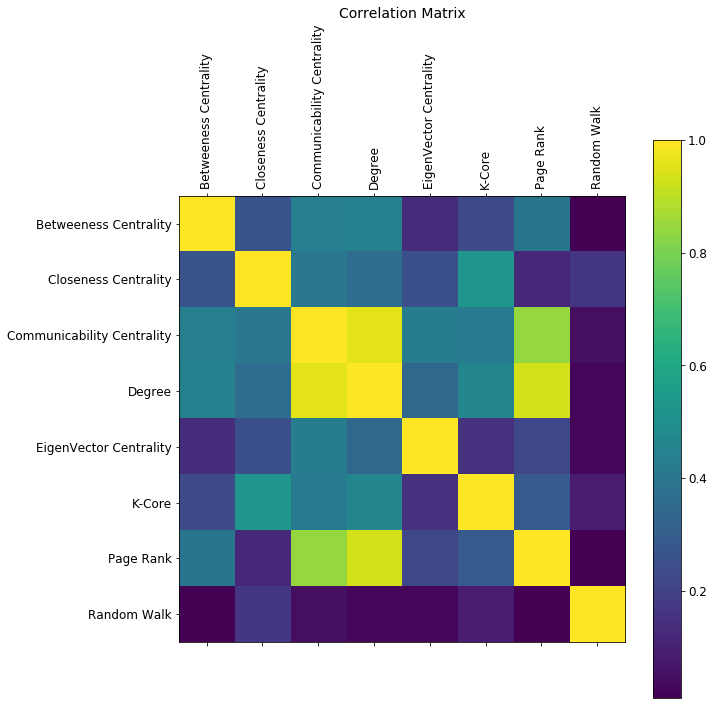

In [5]:
plotCorr(corr[e_road])

Para E-Roads: Poucos atributos possuem alta correlação, portanto todos os atributos trazem informações novas, no entanto caso seja necessário reduzir os atributos removeria dois dentre {PageRank, Degree e Comunicability Centrality}. Caso precisasse deixar apenas 2 atributos deixaria Random Walk e Closeness Centrality, pois tem correlação próxima de 0.

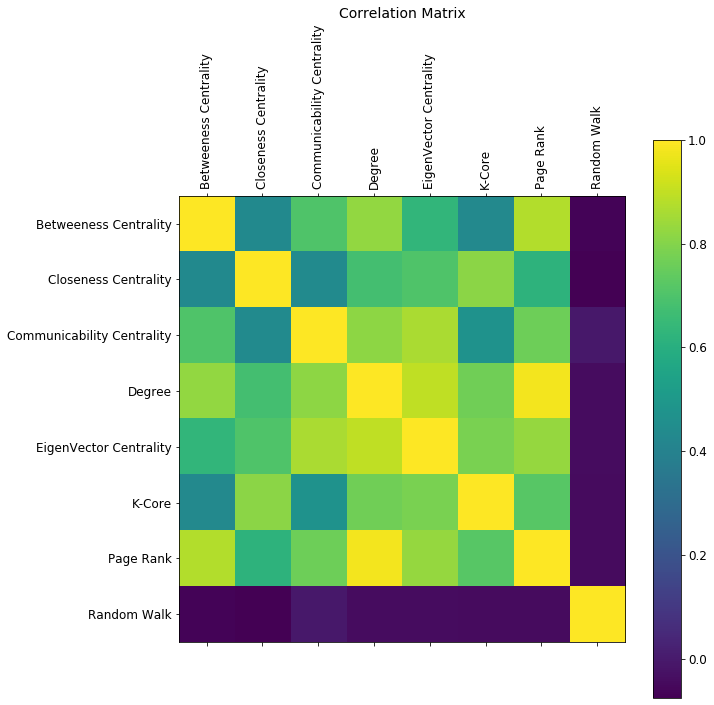

In [6]:
plotCorr(corr[ham])

Para Hamsterster Friends: Muitos atributos são correlacionados, exceto pelo Random Walk. Utilizaria poucos atributos para descrever a base: {Random Walk, K-Core, Communicability Centrlity} talvez Closeness Centrality.

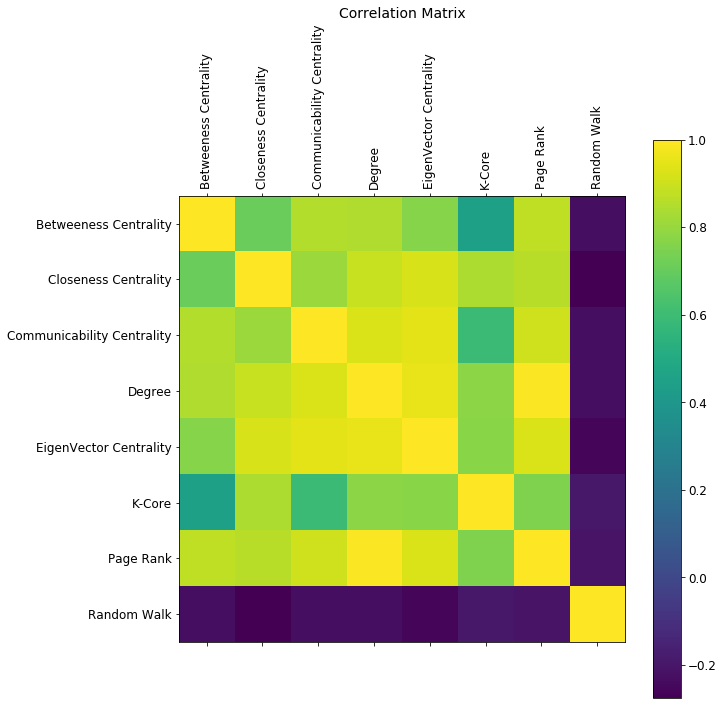

In [7]:
plotCorr(corr[celegans])

Para Celegans: temos resultados similares aos obtidos na Hamsterster Friends, mas os atributos são ainda mais correlacionados, utilizaria apenas {Random Walk, K-Core} + {Betweeness ou Communicability}.

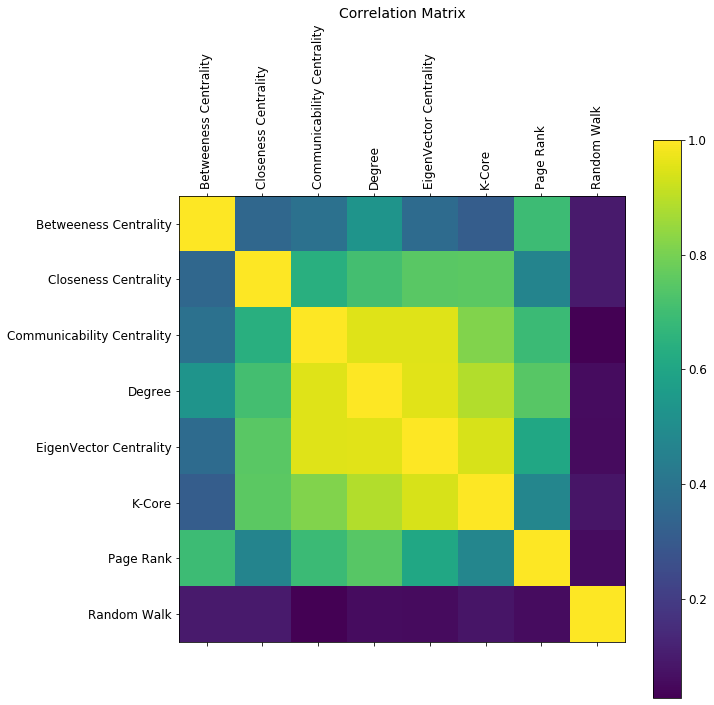

In [8]:
plotCorr(corr[airport])

Para Airport: similar a E-Roads, mas possuindo mais atributos correlacionados que E-Roads, utilizaria, {Random Walk, Betweeness, Closeness, Page Rank}.

Podemos ver que a configuração das bases influencia na relação entre features, e plotar a correlação dos atributos pode ajudar a reduzir a quantidade de features utilizada para descrever essas bases.

### Questão 2

<Figure size 1800x1800 with 0 Axes>

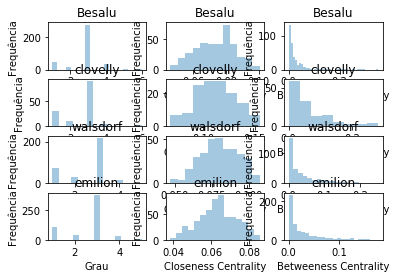

In [9]:
#Ajustar, pois as imagens estão pequenas.
plt.figure(figsize=(25,25));
fig, axis = plt.subplots(4,3)
ng = 0
metric= -1

for g, title in allCities:
    degree = degrees(g)
    closenessC = closenessCentrality(g)
    betweeness = betweenessCentrality(g)
    
    #Plotando
    metric = (metric + 1) % 3
    axis[ng,metric].set_title(title)
    axis[ng,metric].set_xlabel('Grau')
    axis[ng,metric].set_ylabel('Frequência')
    sns.distplot(degree, hist=True, kde=False, ax=axis[ng,metric]);
    
    metric = (metric + 1) % 3
    axis[ng,metric].set_title(title)
    axis[ng,metric].set_xlabel('Closeness Centrality')
    axis[ng,metric].set_ylabel('Frequência')
    sns.distplot(closenessC, hist=True, kde=False, ax=axis[ng,metric]);
    
    metric = (metric + 1) % 3
    axis[ng,metric].set_title(title)
    axis[ng,metric].set_xlabel('Betweeness Centrality')
    axis[ng,metric].set_ylabel('Frequência')
    sns.distplot(betweeness, hist=True, kde=False, ax=axis[ng,metric]);
    ng += 1


Emilion e Walsdorf parecem mais simples de se navegar, uma vez que muitos caminhos passam pelo mesmo lugar (centro provavelmente), Besalu parece ter várias regiões centrais nesse aspecto. Já a usando closeness centrality vemos que Clovelly, Waldorf e Emilion possuem várias regiões que são próximas das outras, i.e. nós com alto cc, indicando que para aqueles que conhecem os menores caminhos da cidade, podem chegar rapidamente aos seus destinos. Besalu parece ser um pouco mais difícil nesse aspecto.

### Questão 3


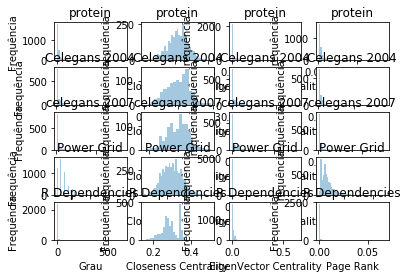

In [10]:
#Ajustar, pois as imagens estão pequenas.
fig, axis = plt.subplots(5,4)
ng = 0
metric= -1

for g, title in [(protein,'protein'), (celegans2004,'Celegans 2004'), (celegans2007,'celegans 2007'),\
                 (power_grid,'Power Grid'), (r_dependencies,'R Dependencies')]:
    
    degree = degrees(g)
    cc = closenessCentrality(g)
    ev = eigenVectorCentrality(g, max_iter = 10000) #1000 estava dando erro em um dos grafos.
    pr = pageRank(g)
    
    #Plotando
    metric = (metric + 1) % 4
    axis[ng,metric].set_title(title)
    axis[ng,metric].set_xlabel('Grau')
    axis[ng,metric].set_ylabel('Frequência')
    sns.distplot(degree, hist=True, kde=False, ax=axis[ng,metric]);
    
    metric = (metric + 1) % 4
    axis[ng,metric].set_title(title)
    axis[ng,metric].set_xlabel('Closeness Centrality')
    axis[ng,metric].set_ylabel('Frequência')
    sns.distplot(cc, hist=True, kde=False, ax=axis[ng,metric]);
    
    metric = (metric + 1) % 4
    axis[ng,metric].set_title(title)
    axis[ng,metric].set_xlabel('EigenVector Centrality')
    axis[ng,metric].set_ylabel('Frequência')
    sns.distplot(ev, hist=True, kde=False, ax=axis[ng,metric]);
    
    metric = (metric + 1) % 4
    axis[ng,metric].set_title(title)
    axis[ng,metric].set_xlabel('Page Rank')
    axis[ng,metric].set_ylabel('Frequência')
    sns.distplot(pr, hist=True, kde=False, ax=axis[ng,metric]);
    ng += 1

As redes biológicas e geográficas possuem apresentaram poucos hubs fortemente conectados. Já a rede de dependências em R possui muitos hubs conectados a outros hubs, demonstrado pela distribuiçãso do Page Rank.

### Questão 4

In [11]:
graphData = []
graph_names = ['protein','Celegans 2004','celegans 2007','Power Grid','R Dependencies']

for g in [protein,celegans2004,celegans2007,power_grid,r_dependencies]:

    description = []
    d = degrees(g)
    cc = closenessCentrality(g)
    kc= kCore(g)
    bc = betweenessCentrality(g)
    ec = eigenVectorCentrality(g,1000)
    pr = pageRank(g)
    rw = random_walk(g,100)
    com = communicabilityCentrality(g)

    for x in [d,kc,cc,bc,ec,pr,rw,com]:
        description.append(np.average(x))
        description.append(np.std(x))
        description.append(moment(x,2))
        description.append(shannonEntropy(x))

    graphData.append(description)


KeyboardInterrupt: 

In [ ]:
#Standarizing
from sklearn import preprocessing
# Get column names first
dataPD = pd.DataFrame(graphData)

names = dataPD.columns
# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
scaled_df = scaler.fit_transform(dataPD)
scaled_graph_data = pd.DataFrame(scaled_df,index= graph_names, columns=names)

#PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(scaled_graph_data)
transformed = pd.DataFrame(data = principalComponents, columns = ['PC 1', 'PC 2'])

plt.figure(figsize=(7,5));
p1 = sns.scatterplot(x='PC 1',y='PC 2', data=transformed, legend=False);

for line in range(0,len(graphData)):
     p1.text(transformed['PC 1'][line], transformed['PC 2'][line], graph_names[line],
     horizontalalignment='left', size='medium', color='black', weight='semibold')

plt.title('PCA Trasformation')
plt.xlabel('PC1')
plt.ylabel('PC2')

Como esperado as redes Celegans são muito similares, já as outras redes, cada uma possui um domínio diferente:

PowerGrid: geográfica, grau segue distribuição de Poisson;

Proteinas: interação de proteínas, lei de Potência e hubs conectados a pontas;

R Dependencies: citação acadêmica, lei de potência, Hubs conectados a hubs;

### Questão 5


In [ ]:
fig, axis = plt.subplots(1,4)
ng = -1
correlations = ""
for g, title in [(e_road,"E-Road"), (celegans,"Celegans Neural"), (airport,"USA Airport"),(protein,'Human Protein')]:
    x, y = knnDegree(g)
    corr = x.corr(y)
    correlations = correlations + "\n"+ title + ": " + str(round(corr,4))
    ng = (ng + 1)
    axis[ng].set_title(title)
    axis[ng].set_xlabel('Grau')
    axis[ng].set_ylabel('Vizinhos Médios Por Grau')
    sns.regplot(x,y, ax=axis[ng]);
    
print(correlations)

Nas redes Airport e Human Protein, conforme o grau aumenta, a quantidade média de vizinhos diminui, indicando que hubs estão conectados a nós pouco conectados, associado a redes dissortativas. Já na Celegans ocorre o inverso. Por fim, na rede E-Roads, apresenta uma rede sem tendência, pois a quantidade de vizinhos de um nó não prevê o grau da vizinhança.

Usando correlação de Pearson podemos ver o quanto o grau de um nó prevê o grau médio de seus vizinhos, além de ser uma medida limitada (-1 a 1), portanto é uma ótima maneira de medir quantitativamente a assortatividade de uma rede.
As redes de Airport e Human Protein, possuem correlação negativa e longe de 0 indicando redes dissortativas, no entanto para a rede de proteínas a relação de que Hubs conectados a nós pouco conectados é mais frequente que na Airport, trazendo um valor absoluto de correlação maior. A rede Celegans possui certa assortatividade mas se aproxima de uma rede sem tendência e a rede E-Roads possui uma correlação muito próxim,a de 0 indicando uma rede sem tendência.

É vválido notar que a correlação de Pearson captura apenas relações lineares entre os atributos, mas uma observação rápida nos gráficos já indica a ausência de outras relações (e.g. de potência).

### Questão 6

Abaixo, o código gera uma rede de benchmark e exibe as comunidades verdadeiras.

In [ ]:
fig, axis = plt.subplots(1,2, figsize=(10,5))
N = 128
tau1 = 3
tau2 = 1.5
mu = 0.04
k =16
minc = 16
maxc = 16
G = LFR_benchmark_graph(n = N, tau1 = tau1, tau2 = tau2, mu = mu, min_degree = k, 
                        max_degree = k, min_community=minc, max_community = maxc, seed = 10)
pos=nx.spring_layout(G)

nx.draw(G, with_labels = False, nodecolor='r', edge_color='b', 
        node_size=50, font_size=16,  width=1,pos = pos, ax=axis[0]);
axis[0].set_title('Grafo de benchmark gerado');


def plot_true_comms_benchmark(G, true_comms, ax=-1):
    colors = list(matplotlib.colors.cnames.values())
    aux = 35

    for c in true_comms:
        nx.draw(G.subgraph(c), pos=pos, node_color = colors[aux], with_labels = False, 
            node_size=50, ax=ax)
        aux = aux+1
        nx.draw_networkx_edges(G, pos, ax=ax)
        
    ax.set_title('Comunidades esperadas')
true_comms = {frozenset(G.nodes[v]['community']) for v in G}
plot_true_comms_benchmark(G, true_comms, axis[1])

Executamos, então, os algoritmos que realizam a detecção de comunidades:

In [ ]:
def select_givan_newman_comms(gn_comm, k=3):
    for i in range(k):
        comm = next(gn_comm)
    sorted_comms = sorted(map(sorted, comm))
    return sorted_comms
    
def plot_givan_newman(G, pos, gn_comms, ax=-1):   
    colors = list(matplotlib.colors.cnames.values())
    aux = 50
    
    for comm in gn_comms:
        nx.draw(G.subgraph(comm), pos=pos, node_color = colors[aux], with_labels = False, 
                node_size=50, ax=ax)
        aux = aux + 1
    nx.draw_networkx_edges(G, pos, ax=ax)
    ax.set_title('Método de Givan Newman')

#Louvain
def plot_louvain(G, pos, louvain_comms, ax=-1):
    colors = list(matplotlib.colors.cnames.values())

    size = float(len(set(louvain_comms.values())))
    count = 0.
    for com in set(louvain_comms.values()) :
        count = count + 1.
        list_nodes = [nodes for nodes in louvain_comms.keys() if louvain_comms[nodes] == com]
        nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 50, 
                               node_color = colors[int(count)], ax=ax)
        
    nx.draw_networkx_edges(G, pos, alpha=0.5, ax=ax)
    ax.set_title('Método de Louvain')
    ax.axis('off')

def plot_label_prop(G, pos, lp_comms, ax=-1):
    colors = list(matplotlib.colors.cnames.values())
    
    aux = 20
    for comm in lp_comms:
        nx.draw(G.subgraph(comm), pos=pos, node_size = 50, node_color = colors[aux], ax=ax)
        aux = aux+1
        
    nx.draw_networkx_edges(G, pos, alpha=0.5, ax=ax)
    ax.set_title('Método de label propagation')

def plot_fast_greedy(G, pos, fg_comms, ax=-1):
    colors = list(matplotlib.colors.cnames.values())
    aux = 20
    
    for c in fg_comms:
        nx.draw(G.subgraph(c), pos=pos, node_color = colors[aux], with_labels = False, 
        node_size=50, ax=ax)
        aux = aux+1
        
    nx.draw_networkx_edges(G, pos, ax=ax)    
    ax.set_title('Método Fast Greedy')

def detect_comms(G):
    true_comms = {frozenset(G.nodes[v]['community']) for v in G}
    gn_comms = select_givan_newman_comms(community.girvan_newman(G), k=3)
    lv_comms = community_louvain.best_partition(G)
    lp_comms = list(community.label_propagation_communities(G))
    fg_comms = greedy_modularity_communities(G)
    
    return true_comms, gn_comms, lv_comms, lp_comms, fg_comms

fig, axis = plt.subplots(1,4, figsize=(16,8))

true_comms, gn_comms, lv_comms, lp_comms, fg_comms = detect_comms(G)
g_comms = [true_comms, gn_comms, lv_comms, lp_comms, fg_comms]

plot_givan_newman(G, pos, gn_comms, ax=axis[0]);
plot_louvain(G, pos, lv_comms, ax=axis[1]);
plot_label_prop(G, pos, lp_comms, ax=axis[2]);
plot_fast_greedy(G, pos, fg_comms, ax=axis[3]);

Por fim, organizamos as comunidades na forma de uma tabela para cálculo do NMI, com o qual será feita a comparação dos diferentes métodos:

In [ ]:
def comms_to_dataframe(true_comms, gn_comms, lv_comms, lp_comms, fg_comms):  
    df = pd.DataFrame(columns=['Target','Girvan-Newmann','Louvain','Label Propagation', 'Fast Greedy'])

    for node in G.nodes():
        df = df.append(pd.Series(name=node));

    for index, comm in enumerate(true_comms):
        for node in comm:
            df['Target'].iloc[node] = index;

    for index, comm in enumerate(gn_comms):
        for node in comm:
            df['Girvan-Newmann'].iloc[node] = index;

    for node, comm in lv_comms.items():
        df['Louvain'].iloc[node] = comm;

    for index, comm in enumerate(lp_comms):
        for node in comm:
            df['Label Propagation'].iloc[node] = index;
            
    for index, comm in enumerate(fg_comms):
        for node in comm:
            df['Fast Greedy'].iloc[node] = index;
    return df

df = comms_to_dataframe(*g_comms)
print(df)

In [ ]:
print('Girvan-Newmann: ', nmi(df['Target'], df['Girvan-Newmann']));
print('Louvain', nmi(df['Target'], df['Louvain']));
print('Label Propagation', nmi(df['Target'], df['Label Propagation']));
print('Fast Greedy', nmi(df['Target'], df['Fast Greedy']));

def calc_nmi(g_comms):
    nmi_df = pd.DataFrame(columns=['Girvan-Newmann','Louvain','Label Propagation','Fast Greedy'])
    for index, comms in enumerate(g_comms):
        nmi_df = nmi_df.append(pd.Series(name=0))
        nmi_df['Girvan-Newmann'].iloc[0] = nmi(df['Target'], df['Girvan-Newmann'])
        nmi_df['Louvain'].iloc[0] = nmi(df['Target'], df['Louvain'])
        nmi_df['Label Propagation'].iloc[0] = nmi(df['Target'], df['Label Propagation'])
        nmi_df['Fast Greedy'].iloc[0] = nmi(df['Target'], df['Fast Greedy'])
        
    return nmi_df

nmi_df = calc_nmi([g_comms])
print(nmi_df)

Os métodos de Louvain e Fast Greedy alcançaram NMI igual a 1, indicando a correta detecção de todas as comunidades. O método de Girvan-Newman atingiu o menor NMI entre todos os algoritmos e, portanto, maior taxa de erros. Isto pode ser confirmado por simples inspeção visual das comunidades encontradas, dado que 4 agrupamentos diferentes na separação original foram classificados como se pertencessem a uma única comunidade. O label propagation atingiu valor intermediário de NMI: é possível verificar pelo menos 2 comunidades que foram agrupadas como se fossem uma só pelo algoritmo.

## Questão 7

A seguir, a rede Zachary Karate Club será carregada através do igraph, para que então os métodos de detecção de comunidades sejam aplicados e tenham seus resultados comparados.

### Rede original

In [ ]:
karate = nx.karate_club_graph()
nx.write_gml(karate, 'ex7')
ig_karate = igraph.Graph.Read('ex7', 'gml')
ig_karate.vs['label'] = [None for v in ig_karate.vs]
ig_layout = ig_karate.layout('fr')

color_map = {'Mr. Hi':'red', 'Officer':'blue'}
node_colors = [color_map[v] for v in ig_karate.vs['club']]

igraph.plot(ig_karate, layout=ig_layout, vertex_color=node_colors, bbox=[0, 0, 300, 300])

### Método de Girvan-Newmann

In [ ]:
igraph.plot(ig_karate.community_edge_betweenness().as_clustering(), layout=ig_layout, bbox=[0,0,300,300])

O método de Girvan-newman cometeu uma grande quantidade de erros. Nota-se um nó colocado sozinho na comunidade rosa, além das comunidades verde e azul que não existiam no agrupamento original.

### Método de Louvain

In [ ]:
igraph.plot(ig_karate.community_multilevel(), layout=ig_layout, bbox=[0,0,300,300])

Os agrupamentos encontrados pelo método de Louvain parecem pouco melhores do que os do método de Girvan-Newman, sobretudo porque nenhum nó terminou sozinho em uma comunidade. Ainda assim, há 4 comunidades enquanto eram esperadas duas.

### Método de label propagation

In [ ]:
igraph.plot(ig_karate.community_label_propagation(), layout=ig_layout, bbox=[0,0,300,300])

O algoritmo de label propagation encontrou menos comunidades do que os anteriores, tendo, neste aspecto, atingido resultados mais próximos das comunidades presentes na rede original. Não há nós sozinhos. 

### Método Fast Greedy

In [ ]:
igraph.plot(ig_karate.community_fastgreedy().as_clustering(), layout=ig_layout, bbox=[0,0,300,300])

O fast greedy encontrou 3 comunidades. Algumas destas comunidades, ainda assim, formavam uma única comunidade na rede original. Mais erros foram cometidos quando comparado com o label propagation. Além disso, há nós errados na fronteira entre as comunidades verde e azul.

### Método Netcarto (Simulated Annealing)

In [ ]:
igraph.plot(ig_karate.community_spinglass(), layout=ig_layout, bbox=[0,0,300,300])

4 Comunidades foram encontradas pelo Netcarto, aproximando seus resultados aos do método de Girvan-Newman, exceto que não há nós sozinhos.

### Método Infomap

In [ ]:
igraph.plot(ig_karate.community_infomap(), layout=ig_layout, bbox=[0,0,300,300])

O infomap detectou 3 comunidades, aproximando-o do fast greedy. As comunidades verde e azul pertenciam a uma única comunidade na rede original.

## Exercício 8

O Igraph tem a implementação dos algoritmos de detecção de comunidades mas, até onde conseguimos encontrar, não tem métodos para gerar as redes de benchmark. Em razão disso, o código abaixo gera as redes do networkx e exporta para um arquivo GML que será carregado no Igraph.

(Obs: A rede foi reduzida dos 1000 nós que eram solicitados no enunciado em razão do oneroso tempo de processamento)

In [ ]:
N = 400
tau1 = 3
tau2 = 1.5
mu = 0.04
k =16
minc = 20
maxc = 50
mu_values = [round(i,1) for i in np.arange(0.1, 1, 0.1)]
g_comms = []
for index, cur_mu in enumerate(mu_values):
    G = LFR_benchmark_graph(n = N, tau1 = tau1, tau2 = tau2, mu = cur_mu, min_degree = k, 
                    max_degree = k, min_community=minc, max_community = maxc, seed = 10)
    true_comms = list({frozenset(G.nodes[v]['community']) for v in G})
    #print(G.nodes[0])
    for node in G.nodes():
        G.nodes[node]['community'] = true_comms.index(G.nodes[node]['community'])
    nx.write_gml(G, 'datasets/ex8_{}'.format(index))
    print('Gerou grafo p/ mu={}'.format(cur_mu))

Gera-se, então, um dataframe com o valor de NMI para cada algoritmo em função do valor de mu (valor médio de conexões intracomunidades).

In [ ]:
nmi = pd.DataFrame(columns=['mu','Girvan-Newman','Louvain','Label propagation','Fast Greedy','Netcarto','Infomap'])
nmi.set_index('mu')

for index, cur_mu in enumerate(mu_values):
    ig = igraph.Graph.Read('datasets/ex8_{}'.format(index), format='gml')
    ig = ig.clusters().giant()
    true_comm = igraph.VertexClustering.FromAttribute(ig, 'community')
    
    gv = ig.community_edge_betweenness().as_clustering()   
    lv = ig.community_multilevel()
    lp = ig.community_label_propagation()
    fg = ig.community_fastgreedy().as_clustering()
    nc = ig.community_spinglass()
    im = ig.community_infomap()

    gv_nmi = igraph.clustering.compare_communities(true_comm, gv, method='nmi')
    lv_nmi = igraph.clustering.compare_communities(true_comm, lv, method='nmi')
    lp_nmi = igraph.clustering.compare_communities(true_comm, lp, method='nmi')
    fg_nmi = igraph.clustering.compare_communities(true_comm, fg, method='nmi')
    nc_nmi = igraph.clustering.compare_communities(true_comm, nc, method='nmi')
    im_nmi = igraph.clustering.compare_communities(true_comm, im, method='nmi')
    nmi.loc[index] = [cur_mu, gv_nmi, lv_nmi, lp_nmi, fg_nmi, nc_nmi, im_nmi]
    print('Calculou os nmis para mu={}'.format(cur_mu))
nmi

In [ ]:
fig, axis = plt.subplots(1, 1, figsize=(6,4))
sns.set_style('dark')
sns.lineplot(x=nmi['mu'], y=nmi['Girvan-Newman'], label='Girvan-newmann', marker='*')
sns.lineplot(x=nmi['mu'], y=nmi['Louvain'], label='Louvain', marker='s')
sns.lineplot(x=nmi['mu'], y=nmi['Label propagation'], label='Label Propagation', marker='D')

sns.lineplot(x=nmi['mu'], y=nmi['Fast Greedy'], label='Fast Greedy', marker='P')
sns.lineplot(x=nmi['mu'], y=nmi['Netcarto'], label='Netcarto', marker='^')
sns.lineplot(x=nmi['mu'], y=nmi['Infomap'], label='Infomap', marker='o')

axis.set_title('NMI p/ métodos de detecção de comunidades\nN=200, mu variável')
axis.set_ylabel('NMI')
axis.set_xlabel('Mu')
axis.legend(loc='upper right');

O label propagation apresentou o declínio mais rápido entre todos os algoritmos. Até certo valor de mu, os métodos de Louvain e Netcarto apresentaram o melhor desempenho e estavam quase pareados; após mu=0.4, declinaram rapidamente, com o Netcarto atingindo resultados levemente superiores. O método de Girvan-Newman foi capaz de manter um desempenho consistente em valores mais altos de mu, a despeito do menor desempenho do algoritmo em relação aos demais algoritmos em valores baixos de mu.

## Exercício 9

In [ ]:
e_road_n = len(e_road.nodes())
e_road_deg = degrees(e_road).mean()
e_road_assort = nx.degree_assortativity_coefficient(e_road)
e_road_path = nx.average_shortest_path_length(e_road)

celegans_n = len(celegans.nodes())
celegans_deg = degrees(celegans).mean()
celegans_assort = nx.degree_assortativity_coefficient(celegans)
celegans_path = nx.average_shortest_path_length(celegans)

airport_n = len(airport.nodes())
airport_deg = degrees(airport).mean()
airport_assort = nx.degree_assortativity_coefficient(airport)
airport_path = e_road_path = nx.average_shortest_path_length(airport)

protein_n = len(protein.nodes())
protein_deg = degrees(protein).mean()
protein_assort = nx.degree_assortativity_coefficient(protein)
protein_path = e_road_path = nx.average_shortest_path_length(protein)

Para cálculo da modularidade será utilizado o igraph. Em alguns casos, os agrupamentos só funcionaram após a extração do maior componente conexo e remoção de arestas múltiplas.

In [ ]:
e_road_ig = igraph.Graph.Read_Edgelist('datasets/euroroad', directed=False)
e_road_ig = e_road_ig.clusters().giant()
e_road_gv = e_road_ig.community_edge_betweenness().as_clustering()   
e_road_lv = e_road_ig.community_multilevel()
e_road_lp = e_road_ig.community_label_propagation()
e_road_fg = e_road_ig.community_fastgreedy().as_clustering()
print(e_road_gv.modularity)
print(e_road_lv.modularity)
print(e_road_lp.modularity)
print(e_road_fg.modularity)
print('\n')

celegans_ig = igraph.Graph.Read_Edgelist('datasets/C-elegans-frontal.txt', directed=False)
celegans_ig = celegans_ig.clusters().giant()
celegans_ig.simplify(multiple=True)
celegans_gv = celegans_ig.community_edge_betweenness().as_clustering()   
celegans_lv = celegans_ig.community_multilevel()
celegans_lp = celegans_ig.community_label_propagation()
celegans_fg = celegans_ig.community_fastgreedy().as_clustering()
print(celegans_gv.modularity)
print(celegans_lv.modularity)
print(celegans_lp.modularity)
print(celegans_fg.modularity)
print('\n')

In [ ]:
nx.write_gml(airport, 'datasets/ex9_airports')
airports_ig = igraph.Graph.Read('datasets/ex9_airports', format='gml')

airports_gv = airports_ig.community_edge_betweenness().as_clustering()   
airports_lv = airports_ig.community_multilevel()
airports_lp = airports_ig.community_label_propagation()
airports_fg = airports_ig.community_fastgreedy().as_clustering()
print(airports_gv.modularity)
print(airports_lv.modularity)
print(airports_lp.modularity)
print(airports_fg.modularity)

In [ ]:
protein_ig = igraph.Graph.Read_Edgelist('datasets/out.maayan-vidal', directed=False)
protein_ig = protein_ig.clusters().giant()

protein_gv = protein_ig.community_edge_betweenness().as_clustering()   
protein_lv = protein_ig.community_multilevel()
protein_lp = protein_ig.community_label_propagation()
protein_fg = protein_ig.community_fastgreedy().as_clustering()
print(protein_gv.modularity)
print(protein_lv.modularity)
print(protein_lp.modularity)
print(protein_fg.modularity)
print('\n')

### Tabela final

In [ ]:
df9 = pd.DataFrame(columns=['Network','N','Avg. Degree','Assortativity','Avg. Short. Path','Mod. Fast Greedy', 
                            'Mod. Label Prop.', 'Mod. Givan Newman', 'Mod. Louvain'])

df9.loc[0] = ['E-road', e_road_n, e_road_deg, e_road_assort, e_road_path, e_road_gv.modularity, 
              e_road_lv.modularity, e_road_lp.modularity, e_road_fg.modularity]

df9.loc[1] = ['C.elegans', celegans_n, celegans_deg, celegans_assort, celegans_path, celegans_gv.modularity, 
              celegans_lv.modularity, celegans_lp.modularity, celegans_fg.modularity]

df9.loc[2] = ['US Airports', airport_n, airport_deg, airport_assort, airport_path, airports_gv.modularity, 
              airports_lv.modularity, airports_lp.modularity, airports_fg.modularity]

df9.loc[3] = ['Protein', protein_n, protein_deg, protein_assort, protein_path, protein_gv.modularity, 
              protein_lv.modularity, protein_lp.modularity, protein_fg.modularity]

df9

Na rede E-road, onde predominam vértices de grau baixo, houve maior modularidade. Além disso, quando comparada às demais redes, os vértices da E-road tem uma tendência maior que as outras redes de formar conexões entre vértices de graus semelhantes (pela assortatividade) e shortest paths mais longos. É possível constatar que esta rede apresenta componentes densamente populados por vértices de grau baixo, resultando no fato de que poucos vértices teriam grau suficiente parar formar conexões com comunidades diferentes. Isto pode ter influenciado o resultado observado para a modularidade das comunidades, que sugerem que há baixa interação intercomunidades.

O oposto se verifica nas redes C. elegans. Baixa assortatividade e maior ocorrência de vértices de grau maior sugerem que vértices menores formam conexões com vértices de graus diferentes sem um padrão definido. Os menores caminhos são mais curtos, sugerindo maior proximidade entre as comunidades. Estes fatores podem explicar o baixo valor observado para a modularidade em todos os algoritmos.

A rede US airports apresenta o maior número de ocorrências de vértices de grau alto. Junta-se a isso o valor negativo de assortatividade, o que sugere que os vértices de grau menor conectam-se mais aos hubs do que com outros vértices de grau menor. Isto é compreensível dado que se trata de uma rede aeroportos. A modularidade foi baixa para todos os algoritmos, indicando que as comunidades de nós apresentam número considerável de conexões entre si. É possível que o alto grau dos hubs tenha influenciado na modularidade, conectando-se a vértices distantes e assim provocando interações entre comunidades diferentes.

Por fim, a rede protein tem a maior quantidade de vértices, os quais são majoritariamente de grau baixo. A assortatividade apresenta o valor mais negativo de todas as redes, indicando que os nós de grau baixo tem maior tendência a se conectar com vértices de grau alto. Tal qual a rede US Airports, a rede Protein tem assortatividade negativa. No entanto, ao contrário da rede US Airports, a Protein tem grau médio menor: é de se esperar que os hubs, que aqui tem menos conexões, não sejam capazes de interconectar vértices de diferentes comunidades. Isto pode ter resultado na rede Protein ter apresetado o segundo mais alto valor de modularidade observado para todos os algoritmos.


### Exercício 10

Neste exercício, diferentes métricas e algoritmos de detecção de comunidades serão aplicados sobre a rede formada pelas interações entre personagens dos livros da coleção A Song of Ice and Fire (Game of Thrones). Os resultados serão analisados e comparados, e a partir deles serão levantadas hipóteses a respeito do impacto das características da rede no desenvolvimento da história.

Neste grafo, os vértices representam personagens e as arestas ponderadas e direcionadas indicam o número de vezes que as duas personagens apareceram em até 15 palavras de distância uma da outra. A origem da aresta denota o personagem que foi citado primeiro.

In [ ]:
def load_asoiaf():
    asoiaf_edges = pd.read_csv('datasets/asoiaf/data/asoiaf-all-edges.csv')
    edges = [tuple(x) for x in asoiaf_edges[['Source','Target']].values]
    asoiaf = igraph.Graph.TupleList(edges, directed=True)
    asoiaf.vs['label'] = asoiaf.vs['name']
    return asoiaf

asoiaf = load_asoiaf()

In [ ]:
vertex = {}
for index, v in enumerate(asoiaf.vs):
    vertex[index] = asoiaf.degree(v, type='in')+asoiaf.degree(v, type='out')

vertex = sorted(vertex.items(), key=operator.itemgetter(1), reverse=True)
vertex = [v[0] for v in vertex]
vertex=  vertex[30:]
asoiaf.delete_vertices(vertex)

In [ ]:
layout = asoiaf.layout('drl')
igraph.plot(asoiaf, layout=layout, bbox=[0,0,700,700])

Ajustando o tamanho do vértice pelo grau, temos:

In [ ]:
vertex_size = [v for v in asoiaf.degree()]
igraph.plot(asoiaf, layout=layout, vertex_size = vertex_size, bbox=[0,0,700,700])



A seguir, mede-se a importância relativa de cada personagem segundo diferentes critérios de centralidade, ilustrando-o por meio do tamanho de cada vértice.

### Page rank

In [ ]:
asoiaf.vs['pg'] = asoiaf.pagerank()
vertex_size = asoiaf.vs['pg']
igraph.plot(asoiaf, layout=layout, vertex_size=[v*1000 for v in vertex_size])

### Betweenness

In [ ]:
asoiaf.vs['bt'] = asoiaf.betweenness()
vertex_size = asoiaf.vs['bt']
igraph.plot(asoiaf, layout=layout, vertex_size=[v*2 for v in vertex_size])

É evidente que há uma grande discrepância entre as duas métricas de centralidade. O personagem Varys, por exemplo, recebe  grande importância no Page Rank, presumivelmente por estar presente em cenas com outros personagens importantes. Sua importância diminui, no entanto, no betweenness centrality. É possível que isto ocorra por, apesar de estar em cena com personagens importantes, estar relacionado com uma quantidade menor de personagens, implicando na menor quantidade de caminhos atravessando o nó que representa Varys. Fenômeno semelhante ocorre com outros nós mais importantes do Page Rank, como Tywin Lannister.

Os resultados do Page Rank parecem fazer mais sentido em função da narrativa, dado que os nós mais centrais coincidem, com certa precisão, com os personagens que exercem maior influência no desenvolvimento da trama. Curiosamente, a despeito disso, personagens  importantes como Cersei Lannister, Jaime Lannister e Daenerys Targaryen receberam pouca importância nos dois algoritmos.

In [ ]:
asoiaf = load_asoiaf()
asoiaf_df = pd.DataFrame(columns=['Assortativty','Avg.Degree','Degree Std.Dev.','Median Degree','Max.Degree',
                                  'Avg. Shortest Path','Transitivity'])

degs = np.array(asoiaf.degree())
asoiaf_df.loc[0] = [asoiaf.assortativity_degree(), degs.mean(), degs.std(), np.median(degs),asoiaf.maxdegree(),
                       np.mean(asoiaf.shortest_paths(mode='ALL')), asoiaf.transitivity_avglocal_undirected()]
asoiaf_df

A assortatividade negativa favorece a hipótese de que personagens com menor número de conexões tem tendência de interagir com personagens mais conectados, o que possivelmente decorre da característica de narrativas de ficção dos personagens secundários orbitarem em torno dos protagonistas. A transitividade é alta: dois personagens que interagem com um terceiro tendem a interagir entre si. 

É relevante a enorme diferença entre o grau médio e o grau máximo. Isto pode ser resultado dos livros terem grande quantidade de personagems figurantes e ter narração concentrada no desenvolvimento de seus protagonistas, provocando a enorme diferença de participação na história que os graus da rede sugerem. É possível investigar de forma mais detalhada analisando a distribuição de graus conforme abaixo:

In [ ]:
fig, axis = plt.subplots(1,2)
pd.Series(asoiaf.degree()).hist(ax=axis[0]);
axis[0].set_title('Distribuição de grau dos vértices\nA Song of Ice and Fire');
sns.boxplot(asoiaf.degree(), orient='v', ax=axis[1]);
axis[1].set_title('Boxplot: Graus dos vértices\n');

Verifica-se a forte assimetria da distribuição de graus, além da presença de quantidade considerável de outliers densamente conectados. É possível que estes outliers atuem como hubs e contribuam para o valor baixo observado do shortest average path, dado que as suas conexões podem estabelecer caminhos menores entre personagens de baixo grau que, na ausência dos hubs, teriam que percorrer grandes distâncias para interagir.

In [ ]:
deg, count = np.unique(np.array(asoiaf.degree()), return_counts=True)
scatter = sns.scatterplot(x=deg, y=count)
scatter.set(xscale='log', yscale='log')
plt.title('Quantidade de personagens com cada valor de grau\nA song of Ice and Fire');

A distribuição de graus parece seguir uma lei de potências. Isto talvez permita especular sobre o impacto da morte de personagens na narrativa, o que é característica marcante dos livros da série. Redes que seguem a lei de potência são livres de escala, o que implica na robustez a falhas. Neste contexto, isto pode significar que a eliminação aleatória de personagens não deve impactar significativamente a rede de personagens e, por consequência, não deve afetar o andar da narrativa. É plausível supor, no entanto, que a eliminação dos hubs por meio de ataques deve ainda causar impacto, visto que causaria considerável reconfiguração das conexões entre os personagens e, provavelmente, teria reflexos na trama política da série.

Avalia-se esta hipótese analisando alguns destes hubs:

In [ ]:
ranks = np.argsort(np.array(asoiaf.degree()))
print([asoiaf.vs[rank]['name'] for rank in ranks[-1:-10:-1]])

De fato, a remoção de nós como Eddard Stark e Stannis Baratheon redefiniram os rumos da narrativa. É provável que a remoçã ode nós como Tyrion Lannister provocasse ainda maior impacto, dado a sua conectividade.

Por fim, estuda-se as comunidades formadas:

In [ ]:
asoiaf = load_asoiaf()

asoiaf.to_undirected()

gn = asoiaf.community_edge_betweenness().as_clustering()
lv = asoiaf.community_multilevel()
lp = asoiaf.community_label_propagation()
fg = asoiaf.community_fastgreedy().as_clustering()
im = asoiaf.community_infomap()
nc = asoiaf.community_spinglass()

In [ ]:
df_mod = pd.DataFrame(columns=['Girvan-Newman','Louvain','Label propagation','Fast Greedy','Infomap','Netcarto'])
df_mod.loc[0] = [gn.modularity,lv.modularity,lp.modularity,fg.modularity,im.modularity,nc.modularity]
df_mod

O método netcarto foi capaz de atingir o maior valor de modularidade. Inspecionando os resultados, temos:

In [ ]:
vertex = {}
for index, v in enumerate(asoiaf.vs):
    vertex[index] = asoiaf.degree(v, type='in')+asoiaf.degree(v, type='out')

vertex = sorted(vertex.items(), key=operator.itemgetter(1), reverse=True)
vertex = [v[0] for v in vertex]
vertex=  vertex[30:]
asoiaf.delete_vertices(vertex)
nc = asoiaf.community_spinglass()

igraph.plot(nc, layout=layout, bbox=[0,0,700,700])

As comunidades detectadas têm sentido narrativo, dado que refletem a divisão que prevalece ao longo de boa parte da história, em que os cenários se desenvolvem simultaneamente ao norte (com personagens da comunidade vermelha) e ao sul do continente (onde se localizam os personagens da comunidade verde).